In [1]:
import warnings
warnings.filterwarnings('ignore')
# import cv2
import numpy as np
import glob
from keras.models import load_model
import tensorflow as tf
from keras import optimizers
import keras
import segmentation_models as sm

import metric
from architecture import create_model, create_callbacks


BACKUP_MODEL_PATH = "./../Models/backup.h5"
seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 4

ROOT = "./../Data/Hannover/"
TRAIN_DIR = "_Train512/"
BACKBONE = 'resnet34' # 'vgg16'

Segmentation Models: using `keras` framework.


In [2]:
import get_data_generators

no_augmentation = {
"rotation_range": 0,
"width_shift_range": 0,
"height_shift_range": 0,
"fill_mode": "constant",
"cval": 0,
"horizontal_flip": "False",
"vertical_flip": "False",
"validation_split": 0.08
}

augmentation = {
"rotation_range": 90,
"width_shift_range": 0.2,
"height_shift_range": 0.2,
"fill_mode": "constant",
"cval": 0,
"horizontal_flip": "True",
"vertical_flip": "True",
"validation_split": 0.08
}

augmentation = no_augmentation
train_gen, val_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), ROOT + TRAIN_DIR + "Images", ROOT + TRAIN_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed, preprocess_function=sm.get_preprocessing(BACKBONE))

Found 3607 images belonging to 1 classes.
Found 313 images belonging to 1 classes.
Found 3607 images belonging to 1 classes.
Found 313 images belonging to 1 classes.


In [10]:
 """Load Model backup to resume training after crash or break or for pretraining"""
 model = load_model(BACKUP_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.5), "f1-score":sm.metrics.FScore(), "quality":metric.quality()})

In [13]:
# define model
#model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True )
for layer in model.layers:
    layer.trainable = True

opt = keras.optimizers.Adam(LEARNING_RATE)
callbacks = create_callbacks(BACKUP_MODEL_PATH)

model.compile(
    optimizer=opt,
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

Num GPUs Available:  1
Epoch 1/100
902/901 [==============================] - ETA: 0s - loss: 0.5492 - iou_score: 0.2978 - f1-score: 0.4509 - quality: 0.5627
Epoch 1: val_loss improved from inf to 0.59784, saving model to ./../Models\backup.h5
901/901 [==============================] - 302s 334ms/step - loss: 0.5492 - iou_score: 0.2978 - f1-score: 0.4509 - quality: 0.5627 - val_loss: 0.5978 - val_iou_score: 0.2587 - val_f1-score: 0.4006 - val_quality: 0.5129 - lr: 1.0000e-05
Epoch 2/100
902/901 [==============================] - ETA: 0s - loss: 0.5243 - iou_score: 0.3182 - f1-score: 0.4757 - quality: 0.5870
Epoch 2: val_loss did not improve from 0.59784
901/901 [==============================] - 301s 334ms/step - loss: 0.5243 - iou_score: 0.3182 - f1-score: 0.4757 - quality: 0.5870 - val_loss: 0.6040 - val_iou_score: 0.2563 - val_f1-score: 0.3967 - val_quality: 0.5014 - lr: 1.0000e-05
Epoch 3/100
902/901 [==============================] - ETA: 0s - loss: 0.5074 - iou_score: 0.3338 - f1

In [15]:
import datetime

print("Time of saving model:", datetime.datetime.now())

model_path = "./../Models/Binary/512/bike_mapper_pre-train-scratch-resnet34_Train3607_Val313_Test980_No-Aug.h5"
model.save(model_path)

Time of saving model: 2022-10-27 01:27:22.677845


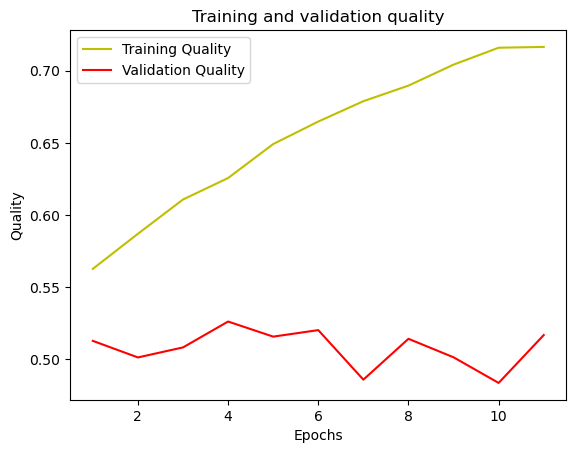

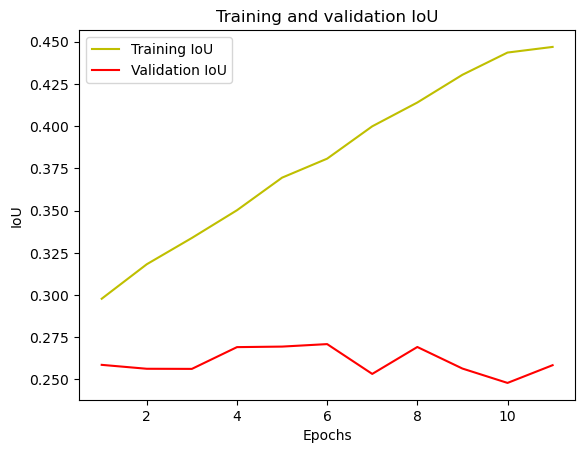

In [16]:
from matplotlib import pyplot as plt

loss = history.history['quality']
val_loss = history.history['val_quality']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Quality')
plt.plot(epochs, val_loss, 'r', label='Validation Quality')
plt.title('Training and validation quality')
plt.xlabel('Epochs')
plt.ylabel('Quality')
plt.legend()
plt.savefig(model_path[:-3] + "__quality.png")

plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.savefig(model_path[:-3] + "__iou.png")
plt.show()

In [4]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
# def iou_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#   union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#   iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
#
#   return iou
#
# def dice_coef(y_true, y_pred, smooth = 1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#
# def soft_dice_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)